In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# from sklearn.linear_model import LinearRegression
mpl.rcParams['figure.dpi']= 200
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['font.size'] = 15
# mpl.rcParams['axes.linewidth'] = 2

RYTOEV = 13.605698 # Rydberg to eV
ryd2mev = RYTOEV*1000

In [3]:
!ls

100Ry
120Ry
50Ry
60Ry
60Ry-BLYP-myrelax
60Ry-LDA-Arpan
60Ry-LDA-myrelax
60Ry-PBE-Arpan
60Ry-PBE-Kresse
60Ry-PBE-myrelax
80Ry
C.pz-mt.fhi.UPF
C_ONCV_PBE-1.0.upf
Compare_direct_and_indirect.png
Diamond_indirect_gap_PBE.png
Diamond_temperature_dependence.png
Diamond_temperature_dependence_DFT.png
Diamond_temperature_dependence_GW.png
Diamond_temperature_dependence_direct.png
Diamond_temperature_dependence_indirect.png
EPCE_gamma_west.csv
Extract_indirect_gap.py
Temperature_dependent_ZPR.ipynb
Temperature_dependent_ZPR.py
Untitled.ipynb
compare_adi_nad_indirect_gap.png
compare_adi_nad_indirect_gap.py
indirect_and_direct_zpr.py
ref-data
welph.out
zprs_pbe_gw_indirect.txt
zprs_pbe_indirect.txt
zprs_pbe_indirect_kr.txt


In [4]:
# Kresse 
kresse_dft = pd.read_csv("./ref-data/2018-Kresse-NJP-fig5-4x4x4-DFT.csv")
kresse_gw = pd.read_csv("./ref-data/2018-Kresse-NJP-fig5-4x4x4-GW.csv")
kresse_dft_indirect = pd.read_csv("./ref-data/2018-Kresse-NJP-fig6-5x5x5-DFT.csv")
kresse_dft_indirect["gap"] = (kresse_dft_indirect["gap"]-kresse_dft_indirect["gap"].values[0])*1000

# Antonius 2014
antonius_dfpt = pd.read_csv("./ref-data/2014-Antonius-PRL-fig3-DFPT.csv")
antonius_dfpt["zpr"] = ( antonius_dfpt["gap"] - antonius_dfpt["gap"].values[0] ).values * 1000

antonius_dfpt_gw = pd.read_csv("./ref-data/2014-Antonius-PRL-fig3-DFPT+GW.csv")
antonius_dfpt_gw["zpr"] = ( antonius_dfpt_gw["gap"] - antonius_dfpt_gw["gap"].values[0] ).values * 1000

# Bartomeu Monserrat, PHYSICAL REVIEW B 93, 100301(R) (2016)
monserrat_dfpt = pd.read_csv("./ref-data/2016-Monserrat-PRB-DFPT.csv")
monserrat_dfpt_gw = pd.read_csv("./ref-data/2016-Monserrat-PRB-DFPT+GW.csv")

monserrat_dfpt["zpr"] = ( monserrat_dfpt["zpr"] - monserrat_dfpt["zpr"].values[0]).values
monserrat_dfpt_gw["zpr"] = ( monserrat_dfpt_gw["zpr"] - monserrat_dfpt_gw["zpr"].values[0]).values

# Arpan's frozen phonon calculations with 128 atoms
arpan_fp_128 = pd.read_csv("./ref-data/2021-Arpan-128.csv")
arpan_fp_128["edge"] = ( arpan_fp_128["edge"] - arpan_fp_128["edge"].values[0] ) * 1000
arpan_fp_128["center"] = ( arpan_fp_128["center"] - arpan_fp_128["center"].values[0] ) * 1000


# Experimental direct gap extracted from
# S. Logothetidis, J. Petalas, H. M. Polatoglou, and D. Fuchs
# Phys. Rev. B 46, 4483
gapA1 = pd.read_csv("./ref-data/gapA1.csv")
gapA2 = pd.read_csv("./ref-data/gapA2.csv")
gapB1 = pd.read_csv("./ref-data/gapB1.csv")
gapB2 = pd.read_csv("./ref-data/gapB2.csv")
fitted = pd.read_csv("./ref-data/fitted.csv")
errorbar = pd.read_csv("./ref-data/errorbar.csv")


# extract fitted gap at zero
fitted["Eb-aB"] = fitted["Eb"]-fitted["aB"]
gapA1["gap"] = gapA1["gap"] - fitted[fitted["Data"]=="A1"]["Eb-aB"].values[0]
gapA2["gap"] = gapA2["gap"] - fitted[fitted["Data"]=="A2"]["Eb-aB"].values[0]
gapB1["gap"] = gapB1["gap"] - fitted[fitted["Data"]=="B1"]["Eb-aB"].values[0]
gapB2["gap"] = gapB2["gap"] - fitted[fitted["Data"]=="B2"]["Eb-aB"].values[0]


# eV to meV
gapA1["gap"] = gapA1["gap"]*1000
gapA2["gap"] = gapA2["gap"]*1000
gapB1["gap"] = gapB1["gap"]*1000
gapB2["gap"] = gapB2["gap"]*1000

## Indirect gap ZPR
chen = pd.read_csv("./ref-data/1991-Chen-Diamond-Indirect-ZPR.csv")
chen["gap"] = ( chen["gap"] - chen["gap"].values[0] ) * 1000


In [5]:
def extract_gamma_direct_zpr(prefix,vbm,cbm,enable_gw=False):
    zpr_dft = 0
    zpr_gw  = 0
    fmfname = prefix +"/reFMselfen_DFT_adi.tab"
    dwfname = prefix +"/reDWselfen_DFT.tab"
    fm_dft = pd.read_csv(fmfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
    dw_dft = pd.read_csv(dwfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
    vbm_zpr_dft = fm_dft[np.logical_and(fm_dft["ibn"]==vbm,fm_dft["iks"]==1)]["re"].values[0] + dw_dft[np.logical_and(dw_dft["ibn"]==vbm,dw_dft["iks"]==1)]["re"].values[0]
    cbm_zpr_dft = fm_dft[np.logical_and(fm_dft["ibn"]==cbm,fm_dft["iks"]==1)]["re"].values[0] + dw_dft[np.logical_and(dw_dft["ibn"]==cbm,dw_dft["iks"]==1)]["re"].values[0]
    zpr_dft = cbm_zpr_dft - vbm_zpr_dft

    if ( enable_gw ):
        fmfname = prefix +"/reFMselfen_eqpgw_adi.tab"
        dwfname = prefix +"/reDWselfen_eqpgw.tab"
        fm_gw = pd.read_csv(fmfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
        dw_gw = pd.read_csv(dwfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
        vbm_zpr_gw = fm_gw[np.logical_and(fm_gw["ibn"]==vbm,fm_gw["iks"]==1)]["re"].values[0] + dw_gw[np.logical_and(dw_gw["ibn"]==vbm,dw_gw["iks"]==1)]["re"].values[0]
        cbm_zpr_gw = fm_gw[np.logical_and(fm_gw["ibn"]==cbm,fm_gw["iks"]==1)]["re"].values[0] + dw_gw[np.logical_and(dw_gw["ibn"]==cbm,dw_gw["iks"]==1)]["re"].values[0]
        zpr_gw = cbm_zpr_gw - vbm_zpr_gw
    return zpr_dft, zpr_gw

def extract_indirect_zpr(prefix,vbm,cbm,enable_gw=False):
    zpr_dft = 0
    zpr_gw  = 0
    fmfname = prefix +"/reFMselfen_DFT_adi.tab"
    dwfname = prefix +"/reDWselfen_DFT.tab"
    fm_dft = pd.read_csv(fmfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
    dw_dft = pd.read_csv(dwfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
    vbm_zpr_dft = fm_dft[fm_dft["ibn"]==vbm].sort_values(by="en").tail(1)["re"].values[0] + dw_dft[dw_dft["ibn"]==vbm].sort_values(by="en").tail(1)["re"].values[0]
    cbm_zpr_dft = fm_dft[fm_dft["ibn"]==cbm].sort_values(by="en").head(1)["re"].values[0] + dw_dft[dw_dft["ibn"]==cbm].sort_values(by="en").head(1)["re"].values[0]
    zpr_dft = cbm_zpr_dft - vbm_zpr_dft

    if ( enable_gw ):
        fmfname = prefix +"/reFMselfen_eqpgw_adi.tab"
        dwfname = prefix +"/reDWselfen_eqpgw.tab"
        fm_gw = pd.read_csv(fmfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
        dw_gw = pd.read_csv(dwfname,skiprows=1,sep="\\s+",names=["iks","ibn","en","re","im"])
        vbm_zpr_gw = fm_gw[fm_gw["ibn"]==vbm].sort_values(by="en").tail(1)["re"].values[0] + dw_gw[dw_gw["ibn"]==vbm].sort_values(by="en").tail(1)["re"].values[0]
        cbm_zpr_gw = fm_gw[fm_gw["ibn"]==cbm].sort_values(by="en").head(1)["re"].values[0] + dw_gw[dw_gw["ibn"]==cbm].sort_values(by="en").head(1)["re"].values[0]
        zpr_gw = cbm_zpr_gw - vbm_zpr_gw
    return zpr_dft, zpr_gw

# prefix = "./60Ry/c.welph.save.pdep200.T0"
# zpr_indirect_lda, zpr_indirect_gw = extract_indirect_zpr(prefix,vbm=4,cbm=5,enable_gw=False)
# zpr_direct_lda, zpr_direct_gw = extract_gamma_direct_zpr(prefix,vbm=4,cbm=5,enable_gw=False)
# print(zpr_indirect_lda)
# print(zpr_direct_lda)

## Read ZPRs computed with LDA functional

In [6]:
# Antonius lattice structure
T_lda = [0,100,200,300,400,500,600,700]
zprs_direct_lda = []
zprs_direct_lda_gw = []
for t in T_lda:
    prefix = "./60Ry/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_gamma_direct_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_direct_lda.append(tmp[0])
    zprs_direct_lda_gw.append(tmp[1])

zprs_direct_lda = np.array(zprs_direct_lda) - zprs_direct_lda[0]
zprs_direct_lda_gw = np.array(zprs_direct_lda_gw) - zprs_direct_lda_gw[0]
print(zprs_direct_lda)
print(zprs_direct_lda_gw)

T_lda = [0,100,200,300,400,500,600,700]
zprs_indirect_lda = []
zprs_indirect_lda_gw = []
for t in T_lda:
    prefix = "./60Ry/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_indirect_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_indirect_lda.append(tmp[0])
    zprs_indirect_lda_gw.append(tmp[1])

zprs_indirect_lda = np.array(zprs_indirect_lda) - zprs_indirect_lda[0]
zprs_indirect_lda_gw = np.array(zprs_indirect_lda_gw) - zprs_indirect_lda_gw[0]
print(zprs_indirect_lda)
print(zprs_indirect_lda_gw)

[ 0.00000000e+00 -1.67132000e-02 -7.05764500e-01 -5.10388550e+00
 -1.67999085e+01 -3.65106525e+01 -6.30885825e+01 -9.50357945e+01]
[ 0.00000000e+00 -1.97669000e-02 -1.01499870e+00 -7.18798200e+00
 -2.29862680e+01 -4.90681160e+01 -8.38395190e+01 -1.25351739e+02]
[ 0.00000000e+00 -1.13829000e-02 -6.69587400e-01 -4.82626820e+00
 -1.54731876e+01 -3.30583961e+01 -5.65212974e+01 -8.45554157e+01]
[ 0.00000000e+00 -1.50779000e-02 -7.77301500e-01 -5.17147300e+00
 -1.60261217e+01 -3.36881464e+01 -5.70819033e+01 -8.49195723e+01]


## Read ZPRs computed with PBE functional (Kresse lattice)

In [7]:
T_lda = [0,100,200,300,400,500,600,700]
zprs_direct_pbe_kr = []
zprs_direct_pbe_gw_kr = []
for t in T_lda:
    prefix = "./60Ry-PBE-Kresse/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_gamma_direct_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_direct_pbe_kr.append(tmp[0])
    zprs_direct_pbe_gw_kr.append(tmp[1])

zprs_direct_pbe_kr = np.array(zprs_direct_pbe_kr) - zprs_direct_pbe_kr[0]
zprs_direct_pbe_gw_kr = np.array(zprs_direct_pbe_gw_kr) - zprs_direct_pbe_gw_kr[0]

print(zprs_direct_pbe_kr)
print(zprs_direct_pbe_gw_kr)

T_pbe = [0,100,200,300,400,500,600,700]
zprs_indirect_pbe_kr = []
zprs_indirect_pbe_gw_kr = []
for t in T_lda:
    prefix = "./60Ry-PBE-Kresse/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_indirect_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_indirect_pbe_kr.append(tmp[0])
    zprs_indirect_pbe_gw_kr.append(tmp[1])

zprs_indirect_pbe_kr = np.array(zprs_indirect_pbe_kr) - zprs_indirect_pbe_kr[0]
zprs_indirect_pbe_gw_kr = np.array(zprs_indirect_pbe_gw_kr) - zprs_indirect_pbe_gw_kr[0]

print(zprs_indirect_pbe_kr)
print(zprs_indirect_pbe_gw_kr)

[ 0.0000000e+00 -1.8963000e-02 -8.1106300e-01 -5.6217770e+00
 -1.8066440e+01 -3.8749162e+01 -6.6421572e+01 -9.9526719e+01]
[ 0.00000000e+00 -2.37960000e-02 -1.45629900e+00 -1.03231680e+01
 -3.24506720e+01 -6.83562210e+01 -1.15712238e+02 -1.71860203e+02]
[ 0.00000000e+00 -1.29940000e-02 -7.44166700e-01 -5.18383440e+00
 -1.63090636e+01 -3.44727804e+01 -5.85470675e+01 -8.71935685e+01]
[ 0.00000000e+00 -1.58201000e-02 -8.55429600e-01 -5.72376190e+00
 -1.76337117e+01 -3.68495254e+01 -6.21552906e+01 -9.21524906e+01]


## Read ZPRs computed with PBE functional (Relaxed lattice)

In [8]:
T_lda = [0,100,200,300,400,500,600,700]
zprs_direct_pbe_rlx = []
zprs_direct_pbe_gw_rlx = []
for t in T_lda:
    prefix = "./60Ry-PBE-myrelax/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_gamma_direct_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_direct_pbe_rlx.append(tmp[0])
    zprs_direct_pbe_gw_rlx.append(tmp[1])

zprs_direct_pbe_rlx = np.array(zprs_direct_pbe_rlx) - zprs_direct_pbe_rlx[0]
zprs_direct_pbe_gw_rlx = np.array(zprs_direct_pbe_gw_rlx) - zprs_direct_pbe_gw_rlx[0]

print(zprs_direct_pbe_rlx)
print(zprs_direct_pbe_gw_rlx)

T_pbe = [0,100,200,300,400,500,600,700]
zprs_indirect_pbe_rlx = []
zprs_indirect_pbe_gw_rlx = []
for t in T_lda:
    prefix = "./60Ry-PBE-myrelax/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_indirect_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_indirect_pbe_rlx.append(tmp[0])
    zprs_indirect_pbe_gw_rlx.append(tmp[1])

zprs_indirect_pbe_rlx = np.array(zprs_indirect_pbe_rlx) - zprs_indirect_pbe_rlx[0]
zprs_indirect_pbe_gw_rlx = np.array(zprs_indirect_pbe_gw_rlx) - zprs_indirect_pbe_gw_rlx[0]

print(zprs_indirect_pbe_rlx)
print(zprs_indirect_pbe_gw_rlx)

[ 0.0000000e+00 -1.7845000e-02 -7.5698600e-01 -5.2991210e+00
 -1.7206889e+01 -3.7168779e+01 -6.4019910e+01 -9.6252984e+01]
[ 0.00000000e+00 -2.23810000e-02 -1.36586200e+00 -9.76602900e+00
 -3.09678660e+01 -6.56383920e+01 -1.11591026e+02 -1.66249720e+02]
[ 0.00000000e+00 -1.22415000e-02 -7.04631500e-01 -4.95132890e+00
 -1.56991833e+01 -3.33666924e+01 -5.68862365e+01 -8.49533195e+01]
[ 0.00000000e+00 -1.50638000e-02 -8.16173200e-01 -5.49359670e+00
 -1.70347961e+01 -3.57721067e+01 -6.05492322e+01 -8.99998772e+01]


## Read ZPRs computed with PBE functional (Arpan lattice)

In [9]:
T_lda = [0,100,200,300,400,500,600,700]
zprs_direct_pbe_ar = []
zprs_direct_pbe_gw_ar = []
for t in T_lda:
    prefix = "./60Ry-PBE-Arpan/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_gamma_direct_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_direct_pbe_ar.append(tmp[0])
    zprs_direct_pbe_gw_ar.append(tmp[1])

zprs_direct_pbe_ar = np.array(zprs_direct_pbe_ar) - zprs_direct_pbe_ar[0]
zprs_direct_pbe_gw_ar = np.array(zprs_direct_pbe_gw_ar) - zprs_direct_pbe_gw_ar[0]

print(zprs_direct_pbe_ar)
print(zprs_direct_pbe_gw_ar)

T_pbe = [0,100,200,300,400,500,600,700]
zprs_indirect_pbe_ar = []
zprs_indirect_pbe_gw_ar = []
for t in T_lda:
    prefix = "./60Ry-PBE-Arpan/c.welph.save.pdep200.T%d"%(t)
    tmp = extract_indirect_zpr(prefix,vbm=4,cbm=5,enable_gw=True)
    zprs_indirect_pbe_ar.append(tmp[0])
    zprs_indirect_pbe_gw_ar.append(tmp[1])

zprs_indirect_pbe_ar = np.array(zprs_indirect_pbe_ar) - zprs_indirect_pbe_ar[0]
zprs_indirect_pbe_gw_ar = np.array(zprs_indirect_pbe_gw_ar) - zprs_indirect_pbe_gw_ar[0]

print(zprs_indirect_pbe_ar)
print(zprs_indirect_pbe_gw_ar)

[ 0.00000000e+00 -2.08260000e-02 -9.05843000e-01 -6.20263200e+00
 -1.96202350e+01 -4.16066770e+01 -7.07630350e+01 -1.05443769e+02]
[ 0.00000000e+00 -2.62510000e-02 -1.62309300e+00 -1.13640620e+01
 -3.52213350e+01 -7.34318870e+01 -1.23408981e+02 -1.82342976e+02]
[ 0.00000000e+00 -1.43622000e-02 -8.16920300e-01 -5.60717400e+00
 -1.74063492e+01 -3.64449198e+01 -6.14885001e+01 -9.11409151e+01]
[ 0.00000000e+00 -1.71860000e-02 -9.26890600e-01 -6.13806230e+00
 -1.86978159e+01 -3.87442132e+01 -6.49572292e+01 -9.58843552e+01]


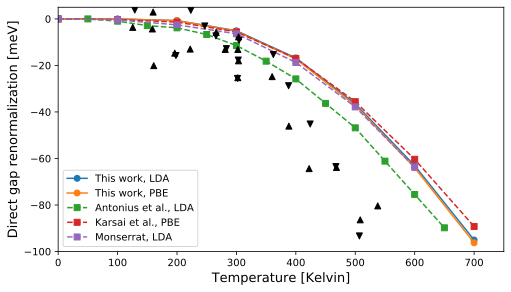

In [10]:
fig = plt.figure(figsize=(8,4.5))
plt.plot(T_lda,zprs_direct_lda,"o-",label="This work, LDA")
# plt.plot(T_pbe,zprs_direct_pbe_kr,"o-",label="This work, PBE, Karsai lattice")
# plt.plot(T_pbe,zprs_direct_pbe_ar,"o-",label="This work, PBE, Kundu lattice")
plt.plot(T_pbe,zprs_direct_pbe_rlx,"o-",label="This work, PBE")


plt.plot(antonius_dfpt["T"],antonius_dfpt["zpr"],"s--",label="Antonius et al., LDA")
plt.plot(kresse_dft["T"],kresse_dft["zpr"],"s--",label="Karsai et al., PBE")
plt.plot(monserrat_dfpt["T"],monserrat_dfpt["zpr"],"s--",label="Monserrat, LDA")

plt.plot(gapA1["T"],gapA1["gap"],"v",c='k')
plt.plot(gapA2["T"],gapA2["gap"],"^",c='k')
# plt.plot(T_lda,zprs_direct_lda_gw,"o-",label="This work, ZPR@GW@LDA")
plt.legend(fontsize=10,loc="lower left")
plt.xlim([0,750])
plt.ylim([-100,5])
plt.xlabel("Temperature [Kelvin]",fontsize=13)
plt.ylabel("Direct gap renormalization [meV]",fontsize=13)
plt.show()
fig.savefig("Diamond_temperature_dependence_direct.png",dpi=200,bbox_inches="tight")

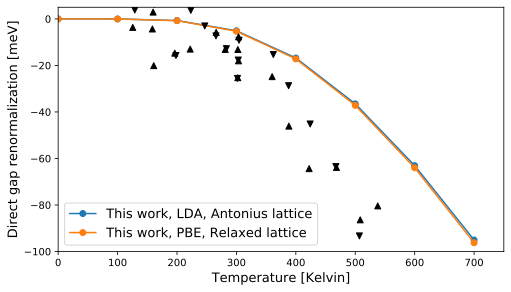

In [11]:
fig = plt.figure(figsize=(8,4.5))
plt.plot(T_lda,zprs_direct_lda,"o-",label="This work, LDA, Antonius lattice")
# plt.plot(T_pbe,zprs_direct_pbe_kr,"o-",label="This work, PBE, Karsai lattice")
# plt.plot(T_pbe,zprs_direct_pbe_ar,"o-",label="This work, PBE, Kundu lattice")
plt.plot(T_pbe,zprs_direct_pbe_rlx,"o-",label="This work, PBE, Relaxed lattice")


# plt.plot(antonius_dfpt["T"],antonius_dfpt["zpr"],"s--",label="Antonius et al., LDA")
# plt.plot(kresse_dft["T"],kresse_dft["zpr"],"s--",label="Karsai et al., PBE")
# plt.plot(monserrat_dfpt["T"],monserrat_dfpt["zpr"],"s--",label="Monserrat, LDA")

plt.plot(gapA1["T"],gapA1["gap"],"v",c='k')
plt.plot(gapA2["T"],gapA2["gap"],"^",c='k')
# plt.plot(T_lda,zprs_direct_lda_gw,"o-",label="This work, ZPR@GW@LDA")
plt.legend(fontsize=13,loc="lower left")
plt.xlim([0,750])
plt.ylim([-100,5])
plt.xlabel("Temperature [Kelvin]",fontsize=13)
plt.ylabel("Direct gap renormalization [meV]",fontsize=13)
plt.show()

# fig.savefig("Diamond_temperature_dependence_direct.png",dpi=200,bbox_inches="tight")

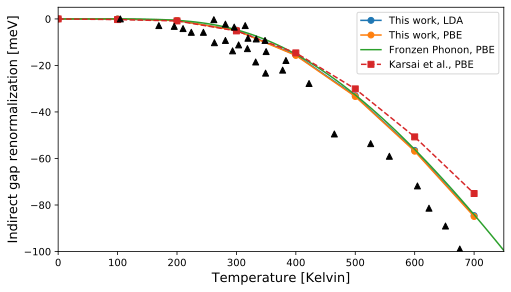

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(8,4.5))
ax = plt.gca()
plt.plot(T_lda,zprs_indirect_lda,"o-",label="This work, LDA",c="C0")
plt.plot(T_pbe,zprs_indirect_pbe_rlx,"o-",label="This work, PBE",c="C1")

plt.plot(arpan_fp_128["T"],arpan_fp_128["center"],"-",label="Fronzen Phonon, PBE",c="C2")

plt.plot(kresse_dft_indirect["T"],kresse_dft_indirect["gap"],"s--",label="Karsai et al., PBE",c="C3")
plt.legend(fontsize=10,loc="upper right")
plt.plot(chen["T"],chen["gap"],"^",c='k')


plt.xlim([0,750])
plt.ylim([-100,5])
plt.xlabel("Temperature [Kelvin]",fontsize=13)
plt.ylabel("Indirect gap renormalization [meV]",fontsize=13)

# axin = inset_axes(ax,  width="65%", height="65%",loc=3,bbox_to_anchor=(.075, .1, .75, .75),bbox_transform=ax.transAxes,)
# axin.plot(T_pbe,zprs_indirect_pbe_rlx,"o-",label="Relaxed lattice",c="C1")
# axin.plot(T_pbe,zprs_indirect_pbe_kr,"o-",label="Karsai lattice",c="C4")
# axin.plot(T_pbe,zprs_indirect_pbe_ar,"o-",label="Kundu lattice",c="C5")
# plt.plot(arpan_fp_128["T"],arpan_fp_128["center"],"-",label="Fronzen Phonon",c="C2")
# plt.xlim([500,700])
# plt.ylim([-100,-25])
# plt.legend(loc="lower left",fontsize=9)
plt.show()
fig.savefig("Diamond_temperature_dependence_indirect.png",dpi=200,bbox_inches="tight")


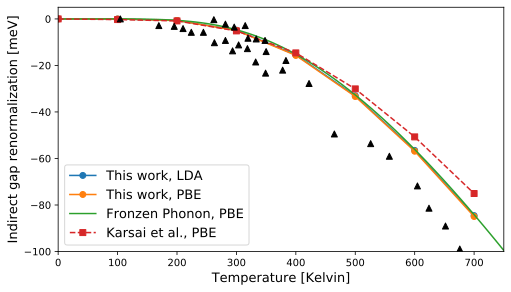

In [13]:
fig = plt.figure(figsize=(8,4.5))
plt.plot(T_lda,zprs_indirect_lda,"o-",label="This work, LDA")
# plt.plot(T_pbe,zprs_indirect_pbe_kr,"o-",label="This work, PBE, Karsai lattice")
# plt.plot(T_pbe,zprs_indirect_pbe_ar,"o-",label="This work, PBE, Kundu lattice")
plt.plot(T_pbe,zprs_indirect_pbe_rlx,"o-",label="This work, PBE")

# plt.plot(T_lda,zprs_indirect_lda_gw,"o-",label="This work, ZPR@GW@LDA")
plt.plot(arpan_fp_128["T"],arpan_fp_128["center"],"-",label="Fronzen Phonon, PBE")

plt.plot(kresse_dft_indirect["T"],kresse_dft_indirect["gap"],"s--",label="Karsai et al., PBE")
plt.legend(fontsize=13,loc="lower left")
plt.plot(chen["T"],chen["gap"],"^",c='k')

plt.xlim([0,750])
plt.ylim([-100,5])
plt.xlabel("Temperature [Kelvin]",fontsize=13)
plt.ylabel("Indirect gap renormalization [meV]",fontsize=13)
plt.show()
fig.savefig("Diamond_temperature_dependence_indirect.png",dpi=200,bbox_inches="tight")